# U-NET and ELU-NET Using Keras

This Code was made for final project and thesis with title "Comparison of U-NET and ELU-NET Deep Learning Architectures for Semantic Segmentation Pancreatic Cancer Medical Images". The model is built using Keras Backend. You can learn U-NET from here https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28 and ELU-NET https://ieeexplore.ieee.org/document/9745574. The code was from https://github.com/sevakon/unet-keras and https://github.com/FrexG/ELU-Net-pytorch. Also for the  dataset, this research using PAIP 2023 dataset challenge with only Pancreatic cancer and 0.250 mpp. You can get the dataset from http://wisepaip.org/challenge2023, but first you need join competition in https://2023paip.grand-challenge.org. Thanks for them who provided so this final project can done.

The article for my thesis will publish soon in Bahasa Indonesia. 

This project need some resource, for simplicity just using Kaggle Notebook or Google Colab. But here is what you need if you want to run in your local project. I recommend you to using Conda as environment. But its okay if you want to using PIP.

1. Anaconda or Miniconda (https://www.anaconda.com/download)
2. Tensorflow with GPU (https://anaconda.org/anaconda/tensorflow-gpu)
3. Numpy (https://numpy.org/install/)
4. PIL (https://anaconda.org/anaconda/pillow)
5. OpenCV (https://anaconda.org/michael_wild/opencv-contrib) 
6. Scikit Image (https://anaconda.org/anaconda/scikit-image)
7. Scikit Learn (https://scikit-learn.org/stable/install.html)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras import backend as keras
import math
from sklearn.model_selection import train_test_split
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

## Importing The image 

This code had never modified so it will be not a clean code. I will modified them after all necessary administration done. The tree of this project is 

    ├───.ipynb_checkpoints
    └───train-tugas-akhir
        ├───train_image
        ├───train_mask
        ├───val_image
        └───val_mask

This cell bellow will return 4 list of images 

    train_image = will contain path RGB images for training model
    train_mask  = will contain path 1 channels image for mask of train_image
    val_image   = will contain path RGB images for testing model
    val_mas     = will contain path 1 channels image for mask val_image

In [ ]:
import os
with open("train_image.txt", "w") as a:
    for path, subdirs, files in os.walk(r'/kaggle/input/train-tugas-akhir/train_image'):
       for filename in files:
         f = os.path.join(path, filename)
         a.write(str(f) + os.linesep)
FileName = ("train_image.txt")
data=open(FileName).readlines()
data.sort()
train_image = []
for i in range(len(data)):
    train_image.append(data[i].rstrip())

import os
with open("train_mask.txt", "w") as a:
    for path, subdirs, files in os.walk(r'/kaggle/input/train-tugas-akhir/train_mask'):
       for filename in files:
         f = os.path.join(path, filename)
         a.write(str(f) + os.linesep)
FileName = ("train_mask.txt")
data=open(FileName).readlines()
data.sort()
train_mask = []
for i in range(len(data)):
    train_mask.append(data[i].rstrip())

import os
with open("val_image.txt", "w") as a:
    for path, subdirs, files in os.walk(r'/kaggle/input/train-tugas-akhir/val_image'):
       for filename in files:
         f = os.path.join(path, filename)
         a.write(str(f) + os.linesep)
FileName = ("val_image.txt")
data=open(FileName).readlines()
data.sort()
val_image = []
for i in range(len(data)):
    val_image.append(data[i].rstrip())

import os
with open("val_mask.txt", "w") as a:
    for path, subdirs, files in os.walk(r'/kaggle/input/train-tugas-akhir/val_mask'):
       for filename in files:
         f = os.path.join(path, filename)
         a.write(str(f) + os.linesep)
FileName = ("val_mask.txt")
data=open(FileName).readlines()
data.sort()
val_mask = []
for i in range(len(data)):
    val_mask.append(data[i].rstrip())

## Pre Processing Image

this pre processing only, from path (train_image, train_mask, val_image, and val_mask) will loaded into `cv2.imread`. only for image (RGB image) will normalize the image using histogram equalization. After that, all image (RGB and mask) will normilize the value into 0-1 (float). For more variety of data, we implement Data Augmentation for Image like flipping horizontally, vertically, and both. After that we cropping the image into 16, so the dimension for an image with width and height respectively is (1024,1024) into 16 images (256,256). all images will store into a list.

`
image_data    = List of image RGB (256,256) for training
mask_data      = List of image mask image_data
val_image_data = List of image RGB (256,256) for testing
val_mask_data  = List of image mask val_image_data
` 

In [ ]:
import cv2
import numpy as np
IMAGE_SIZE = (256,256)

def HistEqual(image):
  ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
  y, cb, cr = cv2.split(ycbcr)
  hist = cv2.equalizeHist(y)
  merged = cv2.merge([hist, cb, cr])
  res = cv2.cvtColor(merged, cv2.COLOR_YCrCb2BGR)
  return res

def crop_image(image, patch_size):
    image_height, image_width, channels = image.shape
    patch_height, patch_width = patch_size

    num_patches_vertical = image_height // patch_height
    num_patches_horizontal = image_width // patch_width

    patches = image[:num_patches_vertical * patch_height, :num_patches_horizontal * patch_width, :]
    patches = np.split(patches, num_patches_vertical, axis=0)
    patches = [np.split(row_patches, num_patches_horizontal, axis=1) for row_patches in patches]
    patches = np.array(patches).reshape(-1, patch_height, patch_width, channels)

    return patches


def devided_image_rgb(image):
  kuadran_1 = image[0:128, 512:, :]
  kuadran_2 = image[0:512, 0:512, :]
  kuadran_3 = image[512:, 0:512, :]
  kuadran_4 = image[512:, 512:, :]
  return kuadran_1, kuadran_2, kuadran_3, kuadran_4

def parse_image(image_path):
  image = cv2.imread(image_path)
  image_equal = HistEqual(image)
  image_equal = cv2.cvtColor(image_equal, cv2.COLOR_BGR2RGB)
  image_equal = image_equal/255
  vertical = crop_image(cv2.flip(image_equal, 0), IMAGE_SIZE)
  horizontal = crop_image(cv2.flip(image_equal, 1), IMAGE_SIZE)
  both = crop_image(cv2.flip(image_equal, -1), IMAGE_SIZE)
  result = crop_image(image_equal, IMAGE_SIZE)
  all_images = np.stack((result, vertical, horizontal, both), axis=0)
  all_images = all_images.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[0], 3)
  return all_images

def devided_image_mask(image_mask):
  image = cv2.imread(image_mask, cv2.IMREAD_UNCHANGED)
  image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  image[image!=0] = 1
  image_reshape = np.reshape(image, (*image.shape, 1))
  vertical = crop_image(np.reshape(cv2.flip(image, 0), (*image.shape, 1)), IMAGE_SIZE)
  horizontal = crop_image(np.reshape(cv2.flip(image, 1), (*image.shape, 1)), IMAGE_SIZE)
  both = crop_image(np.reshape(cv2.flip(image, -1), (*image.shape, 1)), IMAGE_SIZE)
  result = crop_image(image_reshape, IMAGE_SIZE)
  all_images = np.stack((result, vertical, horizontal, both), axis=0)
  all_images = all_images.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[0], 1)
  return all_images

def concat_patch(image_pred_cont):
  dimension = int(1024/np.sqrt(len(image_pred_cont)).astype(np.intc))
  ya = 0
  temp = np.zeros((1024,1024))
  start_point = []
  finish_point = []
  for i in range(np.sqrt(len(image_pred_cont)).astype(np.intc)):
    start_point.append(dimension*i)
    finish_point.append(dimension*(i+1)-1)
  print(start_point)
  print(finish_point)
  for i in range(np.sqrt(len(image_pred_cont)).astype(np.intc)):
    for j in range(np.sqrt(len(image_pred_cont)).astype(np.intc)):
      temp[start_point[j]:finish_point[j]+1,start_point[i]:finish_point[i]+1] = image_pred_cont[ya]
      print(ya)
      ya = ya + 1

  return temp

In [ ]:
mask_data = []
image_data = []
iteration = 0

# count of data is 9
START = 0
FINISH = 35
for image_path, mask_path in zip(train_image, train_mask):
  if START <= FINISH:
    image = parse_image(image_path)
    mask = devided_image_mask(mask_path)
    for i in image:
      image_data.append(i)
    for i in mask:
      mask_data.append(i)
  START = START + 1

In [ ]:
val_mask_data = []
val_image_data = []
iteration = 0

# count of data is 9
START = 0
FINISH = 35

for image_path, mask_path in zip(val_image, val_mask):
  if START <= FINISH:
    image = parse_image(image_path)
    mask = devided_image_mask(mask_path)
    for i in image:
      val_image_data.append(i)
    for i in mask:
      val_mask_data.append(i)
  START = START + 1

Again, after croping, the data will be sequentially. So we need to randomize it using this below. this only randomize the `(image_data,mask_data)` so the data will not sequantially. for memory efficent, we only choose 700 data (from 2304 data, for more details see my article soon or you can send email to algifarir11112002@gmail.com). 700 data is stored into numpy array so it will be like below. We need to make numpy array because the input for training is a tensor.

`(700, 256, 256, 3) for RGB image, (700,256,256,1) for mask`

In [ ]:
import random

# Combine the data and ground truth into pairs
combined = list(zip(image_data, mask_data))

# Shuffle the combined list
random.shuffle(combined)

# Separate the shuffled pairs back into data and ground truth
shuffled_data, shuffled_ground_truth = zip(*combined)

# Convert the tuples back to lists
image_data_random = list(shuffled_data[:700])
mask_data_random = list(shuffled_ground_truth[:700])

trainable_image_random = np.array(image_data_random)
trainable_mask_random = np.array(mask_data_random)

## U-NET

for more details of U-NET you can see at Ronneberger et al https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28. For the code is from https://github.com/sevakon/unet-keras. The  input is `input_size`, for this research is (256,256,3) and `n`, for first channel after Conv2D. This section will contain U-NET function, compile the model, train the model, and save the model.
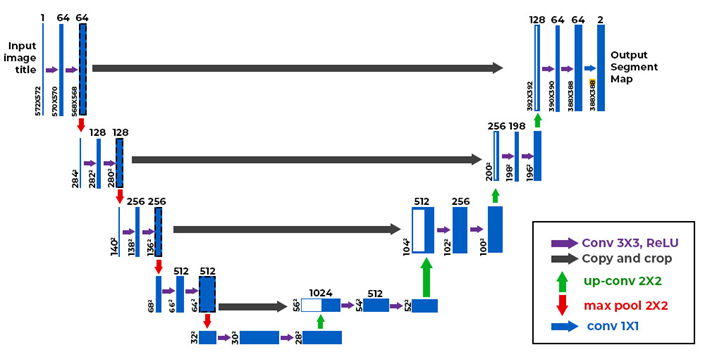

In [ ]:
def unet(pretrained_weights = None,input_size = (256,256,3), n=64):
    inputs = Input(shape=input_size)
    conv1 = Conv2D(n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(2*n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(2*n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(4*n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(4*n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(8*n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(8*n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(16*n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(16*n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(8*n, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = Conv2D(8*n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(8*n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(4*n, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = Conv2D(4*n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(4*n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(2*n, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = Conv2D(2*n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(2*n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(n, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = Conv2D(n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(n, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    unet_model = tf.keras.Model(inputs, conv10, name="U-Net")
    return unet_model


In [ ]:
unet = unet(n=64)
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['accuracy'])
unet.summary()

Assuming using GPU, if not just delete it.

In [ ]:
with tf.device("/GPU:0"):
  history = unet.fit(trainable_image_random, trainable_mask_random, batch_size=8, epochs=40, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

For Save the model

In [ ]:
from keras.models import save_model

unet.save('unet.h5')

For Load the model, for training again after save, just load it and train again using `train()`

In [ ]:
from tensorflow.keras.models import load_model

load = load_model('unet.h5')

## ELU-NET
for more details, see on Deng et al. https://ieeexplore.ieee.org/document/9745574/ the code was already made by FrexG https://github.com/FrexG/ELU-Net-pytorch but using pytorch. So we modified them using keras
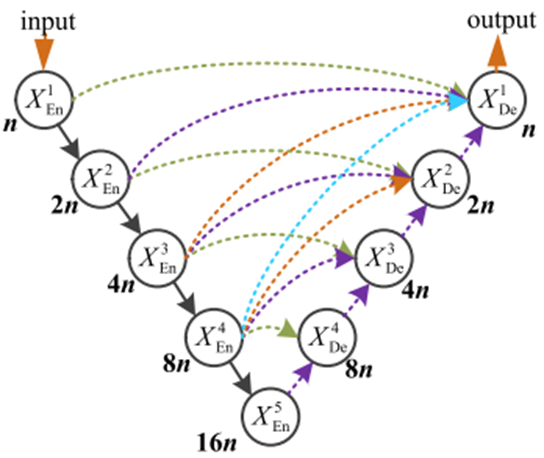
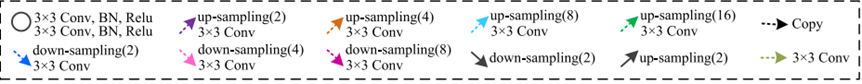

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import math
import tensorflow as tf


def double_conv(out_channels, x, dropout_rate):
  """(Conv2D -> BN -> ReLU) * 2"""
  x = layers.Conv2D(out_channels, 3, padding="same", strides=1)(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Dropout(dropout_rate)(x)
  x = layers.Conv2D(out_channels, 3, padding="same", strides=1)(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Dropout(dropout_rate)(x)
  return x


def down_sample(out_channels, x, dropout_rate):
  """MaxPool2d -> DoubleConv"""
  x = layers.MaxPool2D(2)(x)
  x = double_conv(out_channels, x, dropout_rate)
  return x


def up_sample(in_channels, out_channels, c, x):
  """UpSample by factor c -> Conv2D"""
  if c != 0:
    n = int(math.log(c, 2))
    for _ in range(n):
      x = layers.UpSampling2D(size=(2,2))(x)
  x = layers.Conv2D(out_channels, 3, padding="same", strides=1)(x)
  return x


def out_conv(in_channels, out_channels, x):
  x = layers.Conv2D(out_channels, 1, padding="same", strides=1)(x)
  x = layers.Activation("sigmoid")(x)  # Assuming sigmoid output
  return x


def elunet(size, out_channels, n=8, dropout_rate=0.2, depth_size = 4):
  """ELUnet model in Keras functional API"""
  inputs = layers.Input(shape=(size, size, 3))

  # ------ Input convolution
  # out channel (256, 256, 8))
  x_input = double_conv(n, inputs, dropout_rate)

  # -------- Encoder
  # out channel (128, 128, 16)
  x_enc_1 = down_sample(2 * n, x_input, dropout_rate)

  # out channel (64, 64, 32)
  x_enc_2 = down_sample(4 * n, x_enc_1, dropout_rate)

  #out channel (32, 32, 64)
  x_enc_3 = down_sample(8 * n, x_enc_2, dropout_rate)

  #out channel (16, 16, 128)
  x_enc_4 = down_sample(16 * n, x_enc_3, dropout_rate)

  # -------- Upsampling
  # out channel (32, 32, 64)
  x_up_1 = up_sample(16*n, 8*n, 2, x_enc_4)
  x = keras.layers.Concatenate()([
      x_up_1,
      up_sample(16*n, 8*n, 0, x_enc_3)
      ])
  x_dec_4 = double_conv(8 * n, x, dropout_rate)

  # out channel (64, 64, 32)
  x_up_2 = up_sample(8*n, 4*n, 2, x_dec_4)
  x = keras.layers.Concatenate()([
      x_up_2,
      up_sample(8*n, 4*n, 2, x_enc_3),
      up_sample(4*n, 4*n, 0, x_enc_2)
      ])
  x_dec_3 = double_conv(4 * n, x, dropout_rate)

  # out channel (128, 128, 16)
  x_up_3 = up_sample(4*n, 2*n, 2, x_dec_3)
  x = keras.layers.Concatenate()([
      x_up_3,
      up_sample(8*n, 2*n, 4, x_enc_3),
      up_sample(4*n, 2*n, 2, x_enc_2),
      up_sample(2*n, 2*n, 0, x_enc_1)
  ],)
  x_dec_2 = double_conv(2*n, x, dropout_rate)

  # out channel (256, 256, 8)
  x_up_4 = up_sample(2*n, n, 2, x_dec_2)
  x = keras.layers.Concatenate()([
      x_up_4,
      up_sample(8*n, n, 8, x_enc_3),
      up_sample(4*n, n, 4, x_enc_2),
      up_sample(2*n, n, 2, x_enc_1),
      up_sample(n, n, 0, x_input)
  ])
  x_dec_1 = double_conv(n, x, dropout_rate)

  # out channel (256, 256, 1)
  outputs = out_conv(n, out_channels, x_dec_1)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

In [ ]:
elu = elunet(256, 1, 4, 0.3)
elu.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=keras.losses.BinaryCrossentropy(),
                    metrics=['accuracy'])
elu.summary()

In [ ]:
with tf.device("/GPU:0"):
  history = elu.fit(trainable_image_random, trainable_mask_random, batch_size=16, epochs=40, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

In [ ]:
from keras.models import save_model

elu.save('elu-net.h5')

## Comparing between U-NET and ELU-NET

We using Jaccard Index for calculate the accuracy for inference model

In [ ]:
from tensorflow import keras
from sklearn.metrics import confusion_matrix

def jaccard_index(A, B, cm):
    intersection = np.logical_and(A, B).sum()
    union = np.logical_or(A, B).sum()
    TP = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[1][1]
    return intersection / float(union) if union > 0 else 1.0, (TP/(TP+FN+FP))


def show_test(i, model, x_val, y_val, threshold=127, show_image=False):
    image = np.expand_dims(x_val, axis=0)
    predictions = model.predict(image, verbose = 0)
    # preds_sigmoid = keras.activations.sigmoid(predictions)
    predicted_result = np.squeeze(predictions, axis=0)
    m = keras.metrics.BinaryAccuracy()
    m.update_state(y_val, predicted_result)
    #   tf.print(f'Keras Accuracy\t:',"{:.3f}".format(m.result()))
    #   print(f'Jaccard Index\t:',"{:.3f}".format(jaccard_index(y_val, predicted_result)))
    gray_image = predicted_result[:, :, 0]
    normalized_image = (gray_image * 255).astype(np.uint8)
    _, predicted_result = cv2.threshold(normalized_image, threshold, 255, cv2.THRESH_OTSU)
#     print(np.unique(y_val[:, :, 0]))
#     print(np.unique((predicted_result/255).astype(np.uint8)))
    cm = confusion_matrix(y_val[:, :, 0].astype(np.uint8).flatten(), (predicted_result/255).astype(np.uint8).flatten())
    if show_image:
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))
        # Show the test data on the first subplot
        axes[0].imshow(x_val)
        axes[0].set_title("Data")
        axes[0].axis("off")

        # Show the normalized image on the second subplot
        axes[1].imshow(predicted_result)
        axes[1].set_title("Prediksi")
        axes[1].axis("off")

        axes[2].imshow(y_val)
        axes[2].set_title("Ground Truth")
        axes[2].axis("off")

        # Adjust the spacing between subplots and display the figure
        plt.tight_layout()
        plt.show()
    j_h, j_c = jaccard_index(y_val, predicted_result, cm)
    return j_h, j_c